<a href="https://colab.research.google.com/github/Trung0Minh/AIO2023-MODULE-5/blob/main/mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP for Regression

In [ ]:
!gdown --id 1fB9P1Ha1ofQiYWU9wkLAxDZTbtp3Gfqz

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1fB9P1Ha1ofQiYWU9wkLAxDZTbtp3Gfqz
To: /content/Auto_MPG_data.csv
100% 15.4k/15.4k [00:00<00:00, 34.9MB/s]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
dataset = pd.read_csv('Auto_MPG_data.csv')
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1
...,...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
388,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
389,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
390,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1


In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
val_dataset = dataset.drop(train_dataset.index)

In [ ]:
X_train = train_dataset.copy()
X_val = val_dataset.copy()

y_train = X_train.pop('MPG')
y_val = X_val.pop('MPG')

X_train, y_train = torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32)

In [ ]:
_MEAN = X_train.mean(dim=0)
_STD = X_train.std(dim=0)

X_train = (X_train - _MEAN) / _STD
X_val = (X_val - _MEAN) / _STD

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [ ]:
next(iter(train_loader))

[tensor([[-0.8693, -1.0478, -1.0465, -1.0431,  0.8392,  1.1160, -0.4651,  2.0129,
          -1.2868],
         [-0.8693, -0.7794, -0.3641, -0.4838, -0.5590, -0.7885,  2.1430, -0.4952,
          -1.2868],
         [ 1.4839,  1.0513,  0.6597,  1.0069, -0.0571,  0.8439, -0.4651, -0.4952,
           0.7747],
         [ 1.4839,  1.1759,  1.1846,  1.1254, -0.8458,  0.0277, -0.4651, -0.4952,
           0.7747],
         [ 1.4839,  1.5784,  1.7096,  1.9715, -0.9175, -0.7885, -0.4651, -0.4952,
           0.7747],
         [-0.8693, -0.5302, -0.4953, -0.2373,  0.0146,  1.6601, -0.4651, -0.4952,
           0.7747],
         [ 1.4839,  1.0417,  1.1846,  0.8079, -1.4553, -0.7885, -0.4651, -0.4952,
           0.7747],
         [-0.8693, -0.9520, -0.9415, -0.9495,  0.8751, -1.0605,  2.1430, -0.4952,
          -1.2868],
         [ 0.3073,  0.3516, -0.1278, -0.2385, -0.2005, -0.7885, -0.4651, -0.4952,
           0.7747],
         [-0.8693, -0.5781, -0.5478, -0.7350, -0.9175,  1.6601, -0.4651, -0.4952,


## Linear Regression - MSE

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, input_dims, output_dims):
        super().__init__()
        self.linear = nn.Linear(input_dims, output_dims)

    def forward(self, x):
        return self.linear(x)

In [ ]:
model = LinearRegression(input_dims=9, output_dims=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

## MLP


In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super().__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.relu = nn.ReLU()
        self.layer3 = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        return x

In [ ]:
model = MLP(input_dims=9, hidden_dims=64, output_dims=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

------------------------

In [ ]:
def r_squared(y_true, y_pred):
    """
    Compute R^2 score.
    """
    y_true = torch.Tensor(y_true)
    y_pred = torch.Tensor(y_pred)
    mean_true = torch.mean(y_true)
    ss_tot = torch.sum((y_true - mean_true) ** 2)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [ ]:
num_epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_target = []
    val_target = []
    train_predict = []
    val_predict = []

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        train_predict.extend(outputs.tolist())
        train_target.extend(y.tolist())
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_r2.append(r_squared(train_target, train_predict))

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            val_predict.extend(outputs.tolist())
            val_target.extend(y.tolist())
            loss = criterion(outputs, y)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_r2.append(r_squared(val_target, val_predict))
    print(f"Epoch {epoch+1}/{num_epochs}, Train_Loss: {train_loss:.4f},  Validation Loss: {val_loss:.4f}")

Epoch 1/100, Train_Loss: 591.0184,  Validation Loss: 649.7720
Epoch 2/100, Train_Loss: 544.2532,  Validation Loss: 610.0672
Epoch 3/100, Train_Loss: 501.8646,  Validation Loss: 582.9264
Epoch 4/100, Train_Loss: 461.3788,  Validation Loss: 539.4182
Epoch 5/100, Train_Loss: 426.4895,  Validation Loss: 488.5963
Epoch 6/100, Train_Loss: 388.7451,  Validation Loss: 452.8303
Epoch 7/100, Train_Loss: 358.5723,  Validation Loss: 422.3267
Epoch 8/100, Train_Loss: 329.3069,  Validation Loss: 390.3143
Epoch 9/100, Train_Loss: 301.8825,  Validation Loss: 354.5850
Epoch 10/100, Train_Loss: 278.1217,  Validation Loss: 330.3227
Epoch 11/100, Train_Loss: 255.3828,  Validation Loss: 303.3714
Epoch 12/100, Train_Loss: 232.4089,  Validation Loss: 279.1667
Epoch 13/100, Train_Loss: 214.1591,  Validation Loss: 252.6475
Epoch 14/100, Train_Loss: 197.4661,  Validation Loss: 240.0507
Epoch 15/100, Train_Loss: 181.4547,  Validation Loss: 221.8908
Epoch 16/100, Train_Loss: 166.3098,  Validation Loss: 205.9922
E

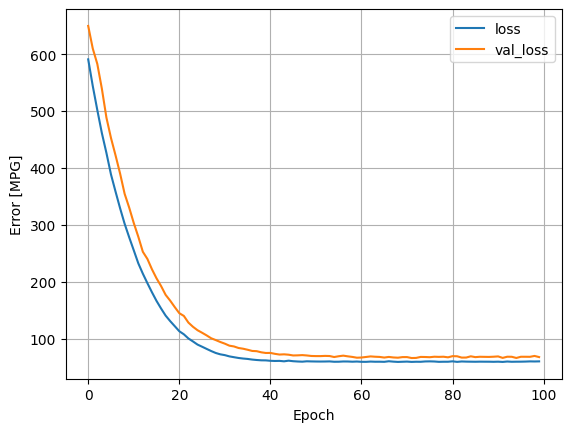

In [ ]:
plt.plot(train_losses, label='loss')
plt.plot(val_losses, label='val_loss')
# plt.ylim([0, 40])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()
plt.grid(True)

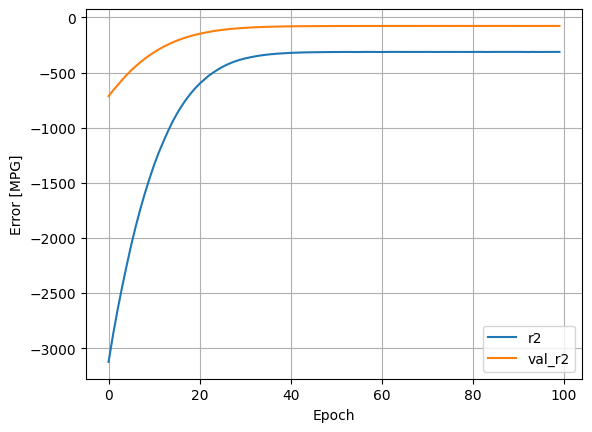

In [ ]:
plt.plot(train_r2, label='r2')
plt.plot(val_r2, label='val_r2')
# plt.ylim([0, 40])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()
plt.grid(True)

# MLP for Classification (non-linear)

In [ ]:
!gdown --id 1bUBWn2Osoc6Y1XskxF_o0JgWVFw0iV_6

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1bUBWn2Osoc6Y1XskxF_o0JgWVFw0iV_6
To: /content/NonLinear_data.npy
100% 5.57k/5.57k [00:00<00:00, 12.8MB/s]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

In [ ]:
data_path = "/content/NonLinear_data.npy"
data = np.load(data_path, allow_pickle=True).item()
X, labels = data["X"], data["labels"].astype(int)
# X, labels = torch.tensor(X, dtype=torch.float32), torch.tensor(labels, dtype=torch.long)
X, labels = torch.tensor(X, dtype=torch.float32), torch.tensor(labels)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # print(idx)
        return self.X[idx], self.y[idx]

In [ ]:
train_dataset = CustomDataset(X, labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

## ReLU

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super().__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

In [ ]:
model = MLP(input_dims=2, hidden_dims=128, output_dims=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

## Softmax

In [ ]:
class SoftMaxRegression(nn.Module):
    def __init__(self, input_dims, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_dims, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        logits = self.linear(x)
        return self.softmax(logits)

In [ ]:
model = SoftMaxRegression(input_dims=2, num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

-----------------------------------

In [ ]:
num_epochs = 200
train_losses = []
train_acc = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    accuracy = 0
    cnt = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        accuracy += (torch.argmax(outputs, 1) == y).sum().item()
        cnt += len(y)
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    accuracy /= cnt
    train_acc.append(accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train_Loss: {train_loss:.4f},  Train_Acc: {accuracy:.4f}")

Epoch 1/500, Train_Loss: 0.9211,  Train_Acc: 0.5300
Epoch 2/500, Train_Loss: 0.9164,  Train_Acc: 0.5267
Epoch 3/500, Train_Loss: 0.9300,  Train_Acc: 0.5233
Epoch 4/500, Train_Loss: 0.9181,  Train_Acc: 0.5267
Epoch 5/500, Train_Loss: 0.9230,  Train_Acc: 0.5233
Epoch 6/500, Train_Loss: 0.9233,  Train_Acc: 0.5200
Epoch 7/500, Train_Loss: 0.9232,  Train_Acc: 0.5233
Epoch 8/500, Train_Loss: 0.9232,  Train_Acc: 0.5233
Epoch 9/500, Train_Loss: 0.9237,  Train_Acc: 0.5233
Epoch 10/500, Train_Loss: 0.9259,  Train_Acc: 0.5200
Epoch 11/500, Train_Loss: 0.9232,  Train_Acc: 0.5200
Epoch 12/500, Train_Loss: 0.9306,  Train_Acc: 0.5267
Epoch 13/500, Train_Loss: 0.9245,  Train_Acc: 0.5233
Epoch 14/500, Train_Loss: 0.9300,  Train_Acc: 0.5233
Epoch 15/500, Train_Loss: 0.9282,  Train_Acc: 0.5233
Epoch 16/500, Train_Loss: 0.9226,  Train_Acc: 0.5233
Epoch 17/500, Train_Loss: 0.9273,  Train_Acc: 0.5233
Epoch 18/500, Train_Loss: 0.9229,  Train_Acc: 0.5233
Epoch 19/500, Train_Loss: 0.9269,  Train_Acc: 0.5233
Ep

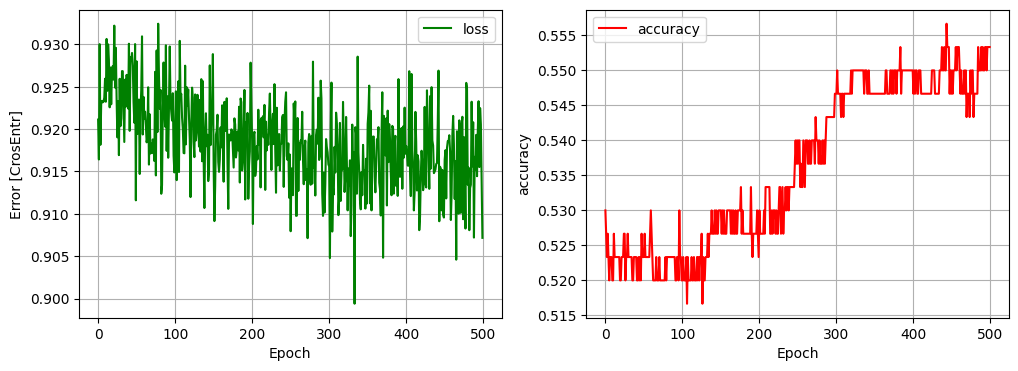

In [ ]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)

# MLP for Classification (image data)

In [1]:
!gdown --id 1bFx6uiQV-GUGwL3PwYRIYdmRCF9hS2bP

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1bFx6uiQV-GUGwL3PwYRIYdmRCF9hS2bP
From (redirected): https://drive.google.com/uc?id=1bFx6uiQV-GUGwL3PwYRIYdmRCF9hS2bP&confirm=t&uuid=9de21683-d629-44aa-8ee1-488984c02728
To: /content/FER-2013.zip
100% 63.3M/63.3M [00:01<00:00, 43.8MB/s]


In [2]:
!unzip -q "/content/FER-2013.zip"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image
import os

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

In [4]:
batch_size = 256
img_height = 180
img_width = 180
image_count = 28709
train_dir = "/content/train"
val_dir = "/content/test"

In [5]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, norm):
        self.resize = Resize((img_height, img_width))
        self.norm = norm
        self.img_dir = img_dir
        self.classes = os.listdir(img_dir)
        self.image_files = [(os.path.join(cls, img), cls) for cls in self.classes for img in os.listdir(os.path.join(img_dir, cls))]
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.idx_to_class = {idx:cls  for cls, idx in self.class_to_idx.items()}

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path, cls = self.image_files[idx]
        image = self.resize(read_image(os.path.join(self.img_dir, img_path)))
        image = image.type(torch.float32)
        label = self.class_to_idx[cls]
        if self.norm:
            image = (image/127.5) - 1
        return image, label

In [6]:
train_dataset = ImageDataset(train_dir, True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageDataset(val_dir, True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [7]:
image_batch, label_batch = next(iter(train_loader))
image_batch.shape, label_batch.shape

(torch.Size([256, 1, 180, 180]), torch.Size([256]))

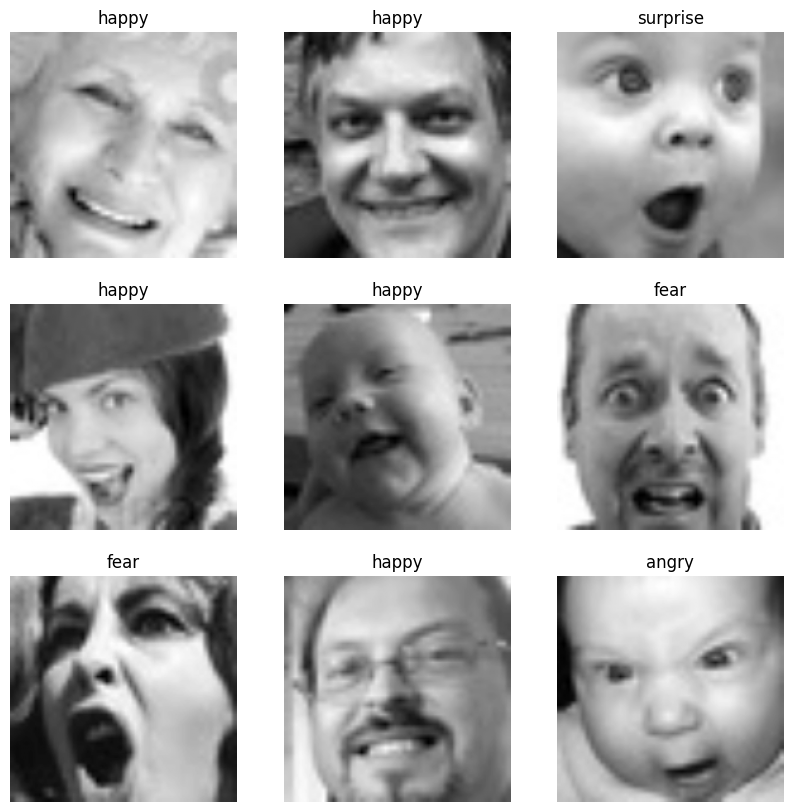

In [8]:
image_batch, label_batch = next(iter(train_loader))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  minv = image_batch[i].numpy().min()
  maxv = image_batch[i].numpy().max()
  plt.imshow(np.squeeze(image_batch[i].numpy()), vmin=minv, vmax=maxv, cmap="gray")
  label = label_batch[i]
  plt.title(train_dataset.idx_to_class[label.item()])
  plt.axis("off")

## Softmax Regression

In [9]:
class SoftMaxRegression(nn.Module):
    def __init__(self, input_dims, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_dims, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.flatten(x, 1)
        logits = self.linear(x)
        return self.softmax(logits)

In [10]:
model = SoftMaxRegression(input_dims=180*180, num_classes=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.006)

## MLP - tanh

In [9]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dims, hidden_dims*4),
            nn.Tanh(),
            nn.Linear(hidden_dims*4, hidden_dims*2),
            nn.Tanh(),
            nn.Linear(hidden_dims*2, hidden_dims),
            nn.Tanh(),
            nn.Linear(hidden_dims, output_dims)
        )

    def forward(self, x):
        x = torch.flatten(x, 1)
        return self.layers(x)

In [10]:
model = MLP(input_dims=180*180, hidden_dims=256, output_dims=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.006)

## MLP - ReLU

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super().__init__()
        self.layers = nn.Sequential([
            nn.Linear(input_dims, hidden_dims*4),
            nn.ReLU(),
            nn.Linear(hidden_dims*4, hidden_dims*2),
            nn.ReLU(),
            nn.Linear(hidden_dims*2, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, output_dims)
        ])

    def forward(self, x):
        x = torch.flatten(x, 1)
        return self.layers(x)

In [ ]:
model = MLP(input_dims=180*180, hidden_dims=256, output_dims=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.006)

----------------------------------------------------------------

In [11]:
num_epochs = 100
train_losses = []
train_acc = []
val_losses = []
val_acc = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    accuracy = 0
    cnt = 0
    for X, y in train_loader:
        X, y = X.to(device).squeeze(), y.to(device)
        optimizer.zero_grad()
        #print(X.shape)
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        accuracy += (torch.argmax(outputs, 1) == y).sum().item()
        cnt += len(y)
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    accuracy /= cnt
    train_acc.append(accuracy)


    model.eval()
    val_loss = 0.0
    val_accuracy = 0
    cnt = 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            val_loss += loss.item()
            val_accuracy += (torch.argmax(outputs, 1) == y).sum().item()
            cnt += len(y)
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy /= cnt
    val_acc.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train_Loss: {train_loss:.4f},  Train_Acc: {accuracy:.4f}, Val_Loss: {val_loss:.4f},  Val_Acc: {val_accuracy:.4f}")

Epoch 1/100, Train_Loss: 1.8415,  Train_Acc: 0.2619, Val_Loss: 1.8024,  Val_Acc: 0.2806
Epoch 2/100, Train_Loss: 1.7742,  Train_Acc: 0.2988, Val_Loss: 1.7567,  Val_Acc: 0.3158
Epoch 3/100, Train_Loss: 1.7360,  Train_Acc: 0.3228, Val_Loss: 1.7213,  Val_Acc: 0.3408
Epoch 4/100, Train_Loss: 1.7054,  Train_Acc: 0.3409, Val_Loss: 1.6974,  Val_Acc: 0.3529
Epoch 5/100, Train_Loss: 1.6839,  Train_Acc: 0.3506, Val_Loss: 1.6833,  Val_Acc: 0.3553
Epoch 6/100, Train_Loss: 1.6710,  Train_Acc: 0.3572, Val_Loss: 1.6713,  Val_Acc: 0.3632
Epoch 7/100, Train_Loss: 1.6601,  Train_Acc: 0.3605, Val_Loss: 1.6647,  Val_Acc: 0.3629
Epoch 8/100, Train_Loss: 1.6523,  Train_Acc: 0.3657, Val_Loss: 1.6618,  Val_Acc: 0.3692
Epoch 9/100, Train_Loss: 1.6458,  Train_Acc: 0.3681, Val_Loss: 1.6544,  Val_Acc: 0.3757
Epoch 10/100, Train_Loss: 1.6378,  Train_Acc: 0.3715, Val_Loss: 1.6510,  Val_Acc: 0.3696
Epoch 11/100, Train_Loss: 1.6328,  Train_Acc: 0.3750, Val_Loss: 1.6483,  Val_Acc: 0.3699
Epoch 12/100, Train_Loss: 1.62

In [12]:
train_loss

0.8759076790472048

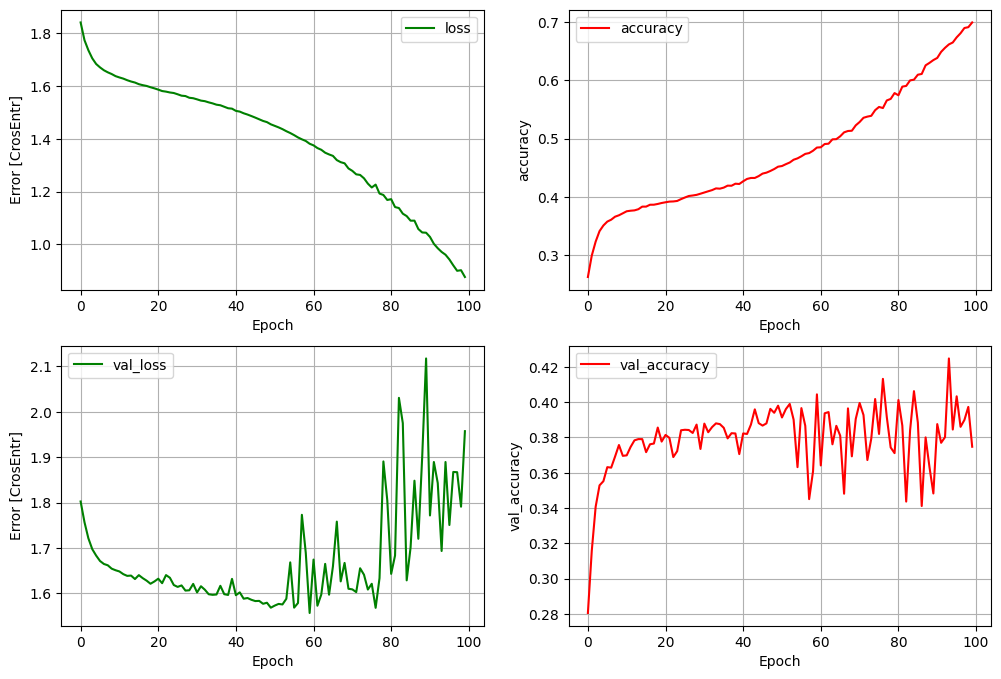

In [13]:
fig = plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(train_acc, label='accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(val_losses, label='val_loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(val_acc, label='val_accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('val_accuracy')
plt.legend()
plt.grid(True)